In [1]:
from openai import OpenAI
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

## Load Data

In [2]:
questions = pd.read_csv('../data/questions.csv', index_col=0)
questions.head()

,question_DE,question_EN,rapide
ID_question,,,
32214,Befürworten Sie eine Erhöhung des Rentenalters...,Do you support an increase in the retirement a...,1
32215,Soll der Staat mehr Mittel für die Krankenkass...,Should the federal government allocate more fu...,1
32216,Bei Ehepaaren ist die Höhe der Rente heute auf...,"For married couples, the pension is currently ...",0
32217,Im Rahmen der BVG-Reform sollen die Renten gek...,As part of the reform of the BVG (occupational...,0
32218,Soll die bezahlte Elternzeit von heute 14 Woch...,Should paid parental leave be increased beyond...,0


In [3]:
ground_truth = pd.read_csv('../data/party_means.csv', index_col=0)
ground_stds = pd.read_csv('../data/party_stds.csv', index_col=0)
ground_truth.head()

,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
32214,0.522222,0.465054,0.979839,0.781046,0.185268,0.503401,0.022222,0.558962,0.278409
32215,0.400000,0.857527,0.108871,0.645425,0.917411,0.675170,0.987037,0.110849,0.615057
32216,0.716667,0.943548,0.673387,0.522876,0.859375,0.933673,0.681481,0.497642,0.784091
32217,0.316667,0.588710,0.899194,0.754902,0.069196,0.693878,0.038889,0.669811,0.264205
32218,0.277778,0.801075,0.197581,0.848039,0.968750,0.744898,0.979630,0.073113,0.569602


## Setup Language Model

In [4]:
APIKEY = open("../APIKEY.txt", "r").read()

client = OpenAI(api_key=APIKEY,organization='org-NfyZox8s9rrIysRhvacfVU4F')

def ask_GPT(party, question, model="gpt-4", temperature=1, n=1):
    messages=[
        {"role": "system", "content": system_prompt(party)},
        {"role": "user", "content": user_prompt(question)}
      ]
    return client.chat.completions.create(model=model,                                          
                                          messages=messages,
                                          temperature=temperature,
                                          n=n,
                                          max_tokens=5,
                                          top_p=1,
                                          frequency_penalty=0,
                                          presence_penalty=0)
 
def content(response, i):
    return response.choices[i].message.content
    
system_prompt = lambda party: f"You are a member of the Swiss party {party}. You have to answer statements based on beliefs of your party. You can only answer with a number between 0 and 100, where 0 means fully disagree and 100 means fully agree. Do not provide reasoning, just the number."
user_prompt = lambda question: f"Rate the following statement: '{question}''"

### Test Run

In [13]:
test_party    = ground_truth.columns[0]
test_question = questions.loc[32214, 'question_EN']

messages=[
    {"role": "system", "content": system_prompt(test_party)},
    {"role": "user", "content": user_prompt(test_question)}
  ]

for i in messages:
    print(i)

{'role': 'system', 'content': 'You are a member of the Swiss party EDU. You have to answer statements based on beliefs of your party. You can only answer with a number between 0 and 100, where 0 means fully disagree and 100 means fully agree. Do not provide reasoning, just the number.'}
{'role': 'user', 'content': "Rate the following statement: 'Do you support an increase in the retirement age (e.g., to 67)?''"}


In [14]:
response = ask_GPT(test_party, test_question, n=3)
response.json()

'{"id": "chatcmpl-AD5GZ1XEzXrDmz4z1bcP9l9QzL1Br", "choices": [{"finish_reason": "stop", "index": 0, "message": {"content": "0", "role": "assistant", "function_call": null, "tool_calls": null, "refusal": null}, "logprobs": null}, {"finish_reason": "stop", "index": 1, "message": {"content": "0", "role": "assistant", "function_call": null, "tool_calls": null, "refusal": null}, "logprobs": null}, {"finish_reason": "stop", "index": 2, "message": {"content": "0", "role": "assistant", "function_call": null, "tool_calls": null, "refusal": null}, "logprobs": null}], "created": 1727681871, "model": "gpt-4-0613", "object": "chat.completion", "system_fingerprint": null, "usage": {"completion_tokens": 3, "prompt_tokens": 94, "total_tokens": 97, "completion_tokens_details": {"reasoning_tokens": 0}}}'

In [15]:
response.choices[2]

Choice(finish_reason='stop', index=2, message=ChatCompletionMessage(content='0', role='assistant', function_call=None, tool_calls=None, refusal=None), logprobs=None)

In [16]:
content(response, 2)

'0'

## Get Answers

In [5]:
answers = {}
for party in ground_truth.columns:
    answers[f'{party}'] = questions.apply(lambda row: ask_GPT(party, 
                                                              row['question_EN'],
                                                              temperature=2, 
                                                              n=10), 
                                          axis=1)
    print(f'Finished {party}')
    
answers = pd.DataFrame(answers)
answers.head()

Finished EDU
Finished EVP
Finished FDP
Finished GLP
Finished Grüne
Finished Mitte
Finished SP
Finished SVP
Finished Übrige


,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
ID_question,,,,,,,,,
32214,ChatCompletion(id='chatcmpl-ADyHCFGesZZUlJa22U...,ChatCompletion(id='chatcmpl-ADyIJZMyNzjIXAe5mK...,ChatCompletion(id='chatcmpl-ADyJIDrZmDPIjxDUs0...,ChatCompletion(id='chatcmpl-ADyKK1Av8iC0XErEB5...,ChatCompletion(id='chatcmpl-ADyLRcfYJ5L8LgOvs3...,ChatCompletion(id='chatcmpl-ADyMXB4ciYrfLVC3sn...,ChatCompletion(id='chatcmpl-ADyNZsYQnhLI3bQXmg...,ChatCompletion(id='chatcmpl-ADyOWeqVXXmT0IOCGJ...,ChatCompletion(id='chatcmpl-ADyPWMQxohZp9eUgKu...
32215,ChatCompletion(id='chatcmpl-ADyHDWdVhYf97jzyzo...,ChatCompletion(id='chatcmpl-ADyIKKjHBkOv16LrBb...,ChatCompletion(id='chatcmpl-ADyJJbSQjWgthN6XBI...,ChatCompletion(id='chatcmpl-ADyKK8wKMqwNrRwL9v...,ChatCompletion(id='chatcmpl-ADyLSCdXEvBQOUr77p...,ChatCompletion(id='chatcmpl-ADyMYB2Klfc8SBx8eS...,ChatCompletion(id='chatcmpl-ADyNaflTwSQqoxNdnT...,ChatCompletion(id='chatcmpl-ADyOXmLafh5ipbVcvI...,ChatCompletion(id='chatcmpl-ADyPWXEMScxn89kIk7...
32216,ChatCompletion(id='chatcmpl-ADyHDgEPrbxdPPZqFi...,ChatCompletion(id='chatcmpl-ADyILQIVLJu1imu4Vn...,ChatCompletion(id='chatcmpl-ADyJKDV9YwS9sL1QzN...,ChatCompletion(id='chatcmpl-ADyKLbOQBHBUZJZx5g...,ChatCompletion(id='chatcmpl-ADyLSQ8hkdKDhHz8ga...,ChatCompletion(id='chatcmpl-ADyMZmHOV5aCETr3ZP...,ChatCompletion(id='chatcmpl-ADyNbW7iHK4y7DUuAL...,ChatCompletion(id='chatcmpl-ADyOYTzvBqNemPl1nB...,ChatCompletion(id='chatcmpl-ADyPXL59DMoN0qUNFo...
32217,ChatCompletion(id='chatcmpl-ADyHG86ghy98fN1lJq...,ChatCompletion(id='chatcmpl-ADyIMj0lbIhlYWu70f...,ChatCompletion(id='chatcmpl-ADyJL5NCrLP8LZM1cI...,ChatCompletion(id='chatcmpl-ADyKMx4OyMGitiV23r...,ChatCompletion(id='chatcmpl-ADyLTqaIZZnACpCpDe...,ChatCompletion(id='chatcmpl-ADyMZVXAxN1KH6aPKh...,ChatCompletion(id='chatcmpl-ADyNcM9Yhd4ayA6zs4...,ChatCompletion(id='chatcmpl-ADyOYZ9CabOBUksNIo...,ChatCompletion(id='chatcmpl-ADyPYFi17M3rFD1puS...
32218,ChatCompletion(id='chatcmpl-ADyHGebWpHWF5wXGgY...,ChatCompletion(id='chatcmpl-ADyIND9FuTNM9pE46X...,ChatCompletion(id='chatcmpl-ADyJLNHdt5N96vSxvD...,ChatCompletion(id='chatcmpl-ADyKNjmylBnU6zS7m2...,ChatCompletion(id='chatcmpl-ADyLUsGxwgbUoie5Eg...,ChatCompletion(id='chatcmpl-ADyMaAcyCqeBTPZRtH...,ChatCompletion(id='chatcmpl-ADyNdxKMBrUNBonUlh...,ChatCompletion(id='chatcmpl-ADyOZMtqfaeWGZmRDe...,ChatCompletion(id='chatcmpl-ADyPYP0wXXb0RseaEF...


In [6]:
# Pickling the object
with open('../results/gpt/2023/gpt4_T20.pickle', 'wb') as file:
    pickle.dump(answers, file)

print("Data has been pickled.")

Data has been pickled.


In [7]:
expand = lambda cell: [content(cell, i) for i in range(10)] 

for party in answers.columns:
    results = answers.loc[:,party].apply(expand)
    results = pd.DataFrame(results.tolist(), index=results.index)
    results = results.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
    print(f'{party}: {results.isna().sum().sum()} NaN values.')
    results.to_csv(f'../results/gpt/2023/gpt4_T20_{party}.csv')


EDU: 20 NaN values.
EVP: 11 NaN values.
FDP: 8 NaN values.
GLP: 19 NaN values.
Grüne: 7 NaN values.
Mitte: 10 NaN values.
SP: 8 NaN values.
SVP: 9 NaN values.
Übrige: 25 NaN values.


## DataFrames

In [8]:
A = pd.read_csv(f'../results/gpt/2023/gpt4_T10_EDU.csv', index_col=0)
A

,0,1,2,3,4,5,6,7,8,9
ID_question,,,,,,,,,,
32214,25,0,0,0,50,0,0,0,0,0
32215,60,50,50,70,50,50,20,50,70,50
32216,0,0,50,0,0,0,0,0,0,0
32217,0,0,0,0,0,0,0,0,0,0
32218,30,30,0,35,40,0,30,30,30,30
...,...,...,...,...,...,...,...,...,...,...
32284,50,30,50,50,70,50,50,50,40,50
32285,50,85,50,60,70,50,75,50,50,70
32286,80,70,80,100,80,80,80,85,60,80


In [13]:
B = pd.read_csv(f'../results/gpt/2023/gpt4_T20_Übrige.csv', index_col=0)
print(B.max().max())
B

250.0


,0,1,2,3,4,5,6,7,8,9
ID_question,,,,,,,,,,
32214,50.0,65.0,63.0,55.0,50.0,52.0,60.0,40.0,50.0,67.0
32215,72.0,50.0,50.0,50.0,58.0,34.0,50.0,60.0,56.0,40.0
32216,50.0,25.0,50.0,50.0,50.0,99.0,53.0,100.0,50.0,60.0
32217,70.0,60.0,0.0,55.0,0.0,0.0,50.0,35.0,20.0,0.0
32218,87.0,51.0,30.0,62.0,67.0,75.0,80.0,60.0,81.0,0.0
...,...,...,...,...,...,...,...,...,...,...
32284,100.0,63.0,100.0,50.0,50.0,65.0,50.0,50.0,65.0,81.0
32285,50.0,50.0,NaN,50.0,70.0,50.0,65.0,48.0,50.0,50.0
32286,50.0,50.0,42.0,60.0,50.0,70.0,70.0,50.0,20.0,75.0


(array([164.,  11.,  75., 111.,  11., 127.,  34.,  77.,  76.,  64.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

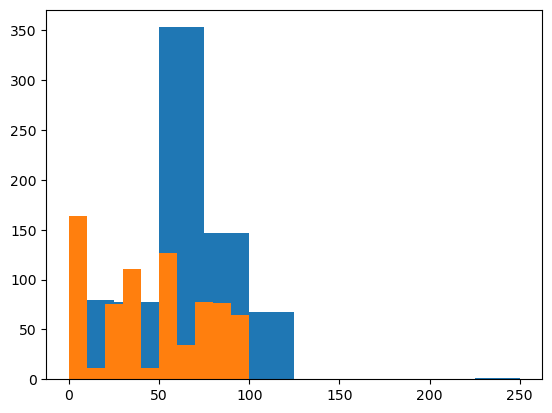

In [10]:
plt.hist(B.values.flatten())
plt.hist(A.values.flatten())